In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd

In [2]:
# Open CAPE, CIN and S06 data
cape = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/wrf_cape/era5_daily_max_mucape_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']
cin = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cin/era5_daily_max_mucin_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']
s06 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/era5_s06_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']

In [3]:
# Open u and v winds
u_6k = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/u_6k/u_6k_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']
v_6k = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/v_6k/v_6k_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']
u_10 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/u10/*s/e5.oper.an.sfc.*.nc', combine='nested', concat_dim='time')['VAR_10U']
v_10 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/v10/*s/e5.oper.an.sfc.*.nc', combine='nested', concat_dim='time')['VAR_10V']

In [4]:
# S06 select only MAMJJA
s06_mamjja = s06.sel(time=s06.time.dt.month.isin([3, 4, 5, 6, 7, 8]))

# S06 subset lats and lons
s06_mamjja = s06_mamjja.sel(latitude=slice(49, 24))
s06_mamjja = s06_mamjja.sel(longitude=slice(235, 294))

# u_6k and v_6k subset lats and lons
u_6k = u_6k.sel(latitude=slice(49, 24))
u_6k = u_6k.sel(longitude=slice(235, 294))

u_6k = u_6k.sel(latitude=slice(49, 24))
u_6k = u_6k.sel(longitude=slice(235, 294))

# u10 and v10 select only mamjja
u10_mamjja = u_10.sel(time=u_10.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
v10_mamjja = v_10.sel(time=v_10.time.dt.month.isin([3, 4, 5, 6, 7, 8]))

# u10 and v10 lat/lon selections
u10_mamjja = u10_mamjja.sel(latitude=slice(49, 24))
u10_mamjja = u10_mamjja.sel(longitude=slice(235, 294))

v10_mamjja = v10_mamjja.sel(latitude=slice(49, 24))
v10_mamjja = v10_mamjja.sel(longitude=slice(235, 294))

In [5]:
# Calculate wind speed for 6k and surface wind
wind_6k = np.sqrt(u_6k ** 2 + v_6k ** 2)
wind_sfc = np.sqrt(u10_mamjja ** 2 + v10_mamjja ** 2)

In [6]:
def calc_ndsev_hoogewind(cape, s06, cin):
    cond = (
        (cape * s06 >= 20000) &
        (cape >= 100) &
        (s06 >= 5) &
        (cin <= 100)
    )
    return cond.astype(int)

In [7]:
def calc_ndsev_trapp_diff(cape, s06, wind_6k, wind_sfc):
    cond = (
        (cape * s06 > 10000) &
        (cape > 100) &
        (s06 > 5) &
        (wind_6k > wind_sfc) & 
        (wind_sfc > 5) & 
        (wind_6k > 5))
    return cond.astype(int)

In [32]:
def calc_ndsev_trapp_diff_old(cape, s06, wind_6k, wind_sfc):
    cond = (
        (cape * s06 > 10000) &
        (cape > 100) &
        (s06 > 5) &
        (wind_6k > wind_sfc))
        # (wind_sfc > 5) & 
        # (wind_6k > 5))
    return cond.astype(int)

In [8]:
# Only want MAM
cape_mam = cape.isel(date=slice(0, 92)).load()
cin_mam = cin.isel(date=slice(0, 92)).load()
s06_mam = s06_mamjja.sel(time=s06_mamjja.time.dt.month.isin([3, 4, 5])).load()
wind_sfc_mam = wind_sfc.sel(time=wind_sfc.time.dt.month.isin([3, 4, 5])).load()
wind_6k_mam = wind_6k.sel(time=wind_6k.time.dt.month.isin([3, 4, 5])).load()

In [9]:
# Need to reshape cape and cin
cape_mam_re = cape_mam.stack(time=('date', 'year')).transpose('time', 'latitude', 'longitude')
cin_mam_re = cin_mam.stack(time=('date', 'year')).transpose('time', 'latitude', 'longitude')

cape_mam_re['time'] = s06_mam['time']
cin_mam_re['time'] = s06_mam['time']

/tmp/ipykernel_214105/75267657.py:5: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['date', 'year'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'date', 'year'])` before assigning new coordinate values.
  cape_mam_re['time'] = s06_mam['time']
/tmp/ipykernel_214105/75267657.py:6: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['date', 'year'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'date', 'year'])` before assigning new coordinate values.
  cin_mam_re['time'] = s06_mam['time']


In [10]:
# Detrending the entire CONUS domain
cape_mam_de = pdo_functions.detrend_dim(cape_mam_re, 'time', 2) + cape_mam_re.mean(dim=('time'))
cin_mam_de = pdo_functions.detrend_dim(cin_mam_re, 'time', 2) + cin_mam_re.mean(dim=('time'))
s06_mam_de = pdo_functions.detrend_dim(s06_mam, 'time', 2) + s06_mam.mean(dim='time')
wind_sfc_mam_de = pdo_functions.detrend_dim(wind_sfc_mam, 'time', 2) + wind_sfc_mam.mean(dim='time')
wind_6k_mam_de = pdo_functions.detrend_dim(wind_6k_mam, 'time', 2) + wind_6k_mam.mean(dim='time')

In [11]:
# Subset a portion of the central US
cape_mam_east = cape_mam_re.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
cin_mam_east = cin_mam_re.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
s06_mam_east = s06_mam.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
wind_sfc_mam_east = wind_sfc_mam.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
wind_6k_mam_east = wind_6k_mam.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

In [12]:
# Subset a portion of the central US - detrended data
cape_mam_east_de = cape_mam_de.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
cin_mam_east_de = cin_mam_de.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
s06_mam_east_de = s06_mam_de.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
wind_sfc_mam_east_de = wind_sfc_mam_de.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
wind_6k_mam_east_de = wind_6k_mam_de.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

In [13]:
# weight by latitude and take spatial mean
weights = np.cos(np.deg2rad(cape_mam_east.latitude))

cape_mam_east_mean = cape_mam_east.weighted(weights).mean(dim=('latitude', 'longitude'))
cin_mam_east_mean = cin_mam_east.weighted(weights).mean(dim=('latitude', 'longitude'))
s06_mam_east_mean = s06_mam_east.weighted(weights).mean(dim=('latitude', 'longitude'))
wind_sfc_mam_east_mean = wind_sfc_mam_east.weighted(weights).mean(dim=('latitude', 'longitude'))
wind_6k_mam_east_mean = wind_6k_mam_east.weighted(weights).mean(dim=('latitude', 'longitude'))

cape_mam_east_de_mean = cape_mam_east_de.weighted(weights).mean(dim=('latitude', 'longitude'))
cin_mam_east_de_mean = cin_mam_east_de.weighted(weights).mean(dim=('latitude', 'longitude'))
s06_mam_east_de_mean = s06_mam_east_de.weighted(weights).mean(dim=('latitude', 'longitude'))
wind_sfc_mam_east_de_mean = wind_sfc_mam_east_de.weighted(weights).mean(dim=('latitude', 'longitude'))
wind_6k_mam_east_de_mean = wind_6k_mam_east_de.weighted(weights).mean(dim=('latitude', 'longitude'))

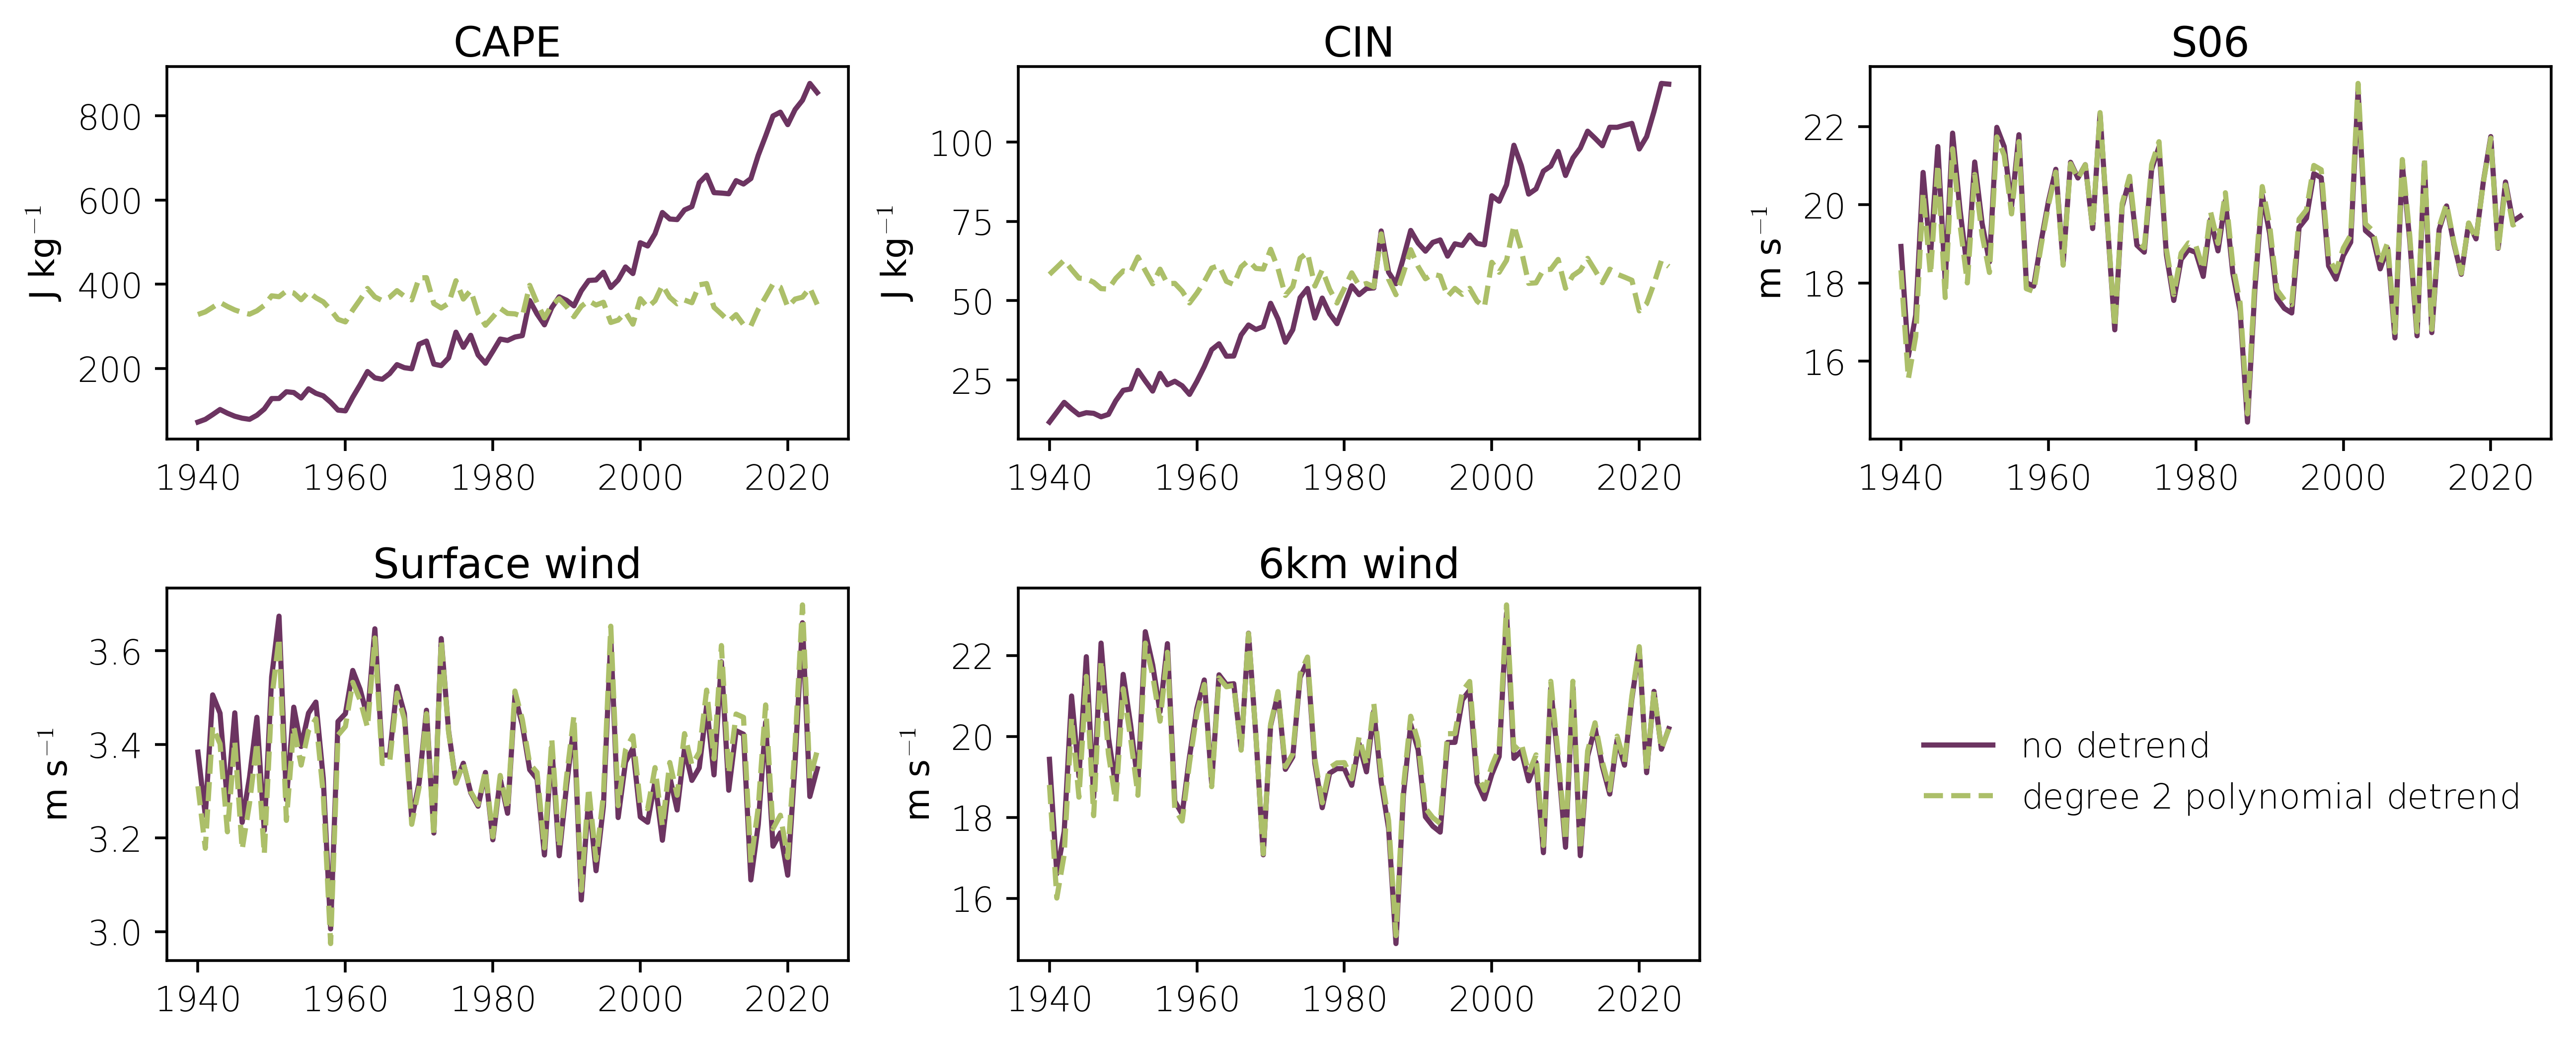

In [14]:
# Plotting time series to compare detrend methods
fig, ax = plt.subplots(2, 3)

no_det = np.zeros((85))
lin_det = np.zeros((85))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

time = np.arange(1940, 2025, 1)

ax[0].plot(time, cape_mam_east_mean.groupby('time.year').mean(), label='no detrend', color='xkcd:grape')
ax[0].plot(time, cape_mam_east_de_mean.groupby('time.year').mean(), label='degree 2 polynomial detrend', linestyle='--', color='xkcd:light olive')

ax[1].plot(time, cin_mam_east_mean.groupby('time.year').mean(), label='no detrend', color='xkcd:grape')
ax[1].plot(time, cin_mam_east_de_mean.groupby('time.year').mean(), label='degree 2 polynomial detrend', linestyle='--', color='xkcd:light olive')

ax[2].plot(time, s06_mam_east_mean.groupby('time.year').mean(), label='no detrend', color='xkcd:grape')
ax[2].plot(time, s06_mam_east_de_mean.groupby('time.year').mean(), label='degree 2 polynomial detrend', linestyle='--', color='xkcd:light olive')

ax[3].plot(time, wind_sfc_mam_east_mean.groupby('time.year').mean(), label='no detrend', color='xkcd:grape')
ax[3].plot(time, wind_sfc_mam_east_de_mean.groupby('time.year').mean(), label='degree 2 polynomial detrend', linestyle='--', color='xkcd:light olive')

ax[4].plot(time, wind_6k_mam_east_mean.groupby('time.year').mean(), label='no detrend', color='xkcd:grape')
ax[4].plot(time, wind_6k_mam_east_de_mean.groupby('time.year').mean(), label='degree 2 polynomial detrend', linestyle='--', color='xkcd:light olive')

ax[5].plot(time, no_det, label='no detrend', color='xkcd:grape')
ax[5].plot(time, lin_det, label='degree 2 polynomial detrend', linestyle='--', color='xkcd:light olive')

for spine in ax[5].spines.values():
    spine.set_color('white')

ax[5].tick_params(axis='both', colors='None')

ax[0].set_title('CAPE', pad=3)
ax[1].set_title('CIN', pad=3)
ax[2].set_title('S06', pad=3)
ax[3].set_title('Surface wind', pad=3)
ax[4].set_title('6km wind', pad=3)

ax[5].legend(frameon=False, bbox_to_anchor=(1., 0.7))
ax[5].set_ylim(1, 1.2)

ax[0].set_ylabel('J kg$^{-1}$')
ax[1].set_ylabel('J kg$^{-1}$')
ax[2].set_ylabel('m s$^{-1}$')
ax[3].set_ylabel('m s$^{-1}$')
ax[4].set_ylabel('m s$^{-1}$')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1.5, 
                    top=1, 
                    wspace=0.25, 
                    hspace=0.4)

In [17]:
np.shape(s06_mam)

(7820, 101, 237)

In [18]:
np.shape(wind_6k_mam)

(7820, 101, 237)

In [19]:
np.shape(wind_sfc_mam)

(7820, 101, 237)

In [33]:
# Calculate NDSEV for each respective month using each method
ndsev_hoogewind = np.zeros((7820, 101, 237))
ndsev_trapp_diff = np.zeros((7820, 101, 237))
ndsev_trapp_diff_old = np.zeros((7820, 101, 237))
for i in range(85):
    ndsev_hoogewind[i*92:i*92 + 31]    = calc_ndsev_hoogewind(cape_mam_re[i*92: (i+1)*92][0:31].values, s06_mam[i*92: (i+1)*92][0:31].values, cin_mam_re[i*92: (i+1)*92][0:31].values)
    ndsev_hoogewind[i*92 + 31:i*92 + 61] = calc_ndsev_hoogewind(cape_mam_re[i*92: (i+1)*92][31:61].values, s06_mam[i*92: (i+1)*92][31:61].values, cin_mam_re[i*92: (i+1)*92][31:61].values)
    ndsev_hoogewind[i*92 + 61:(i+1)*92] = calc_ndsev_hoogewind(cape_mam_re[i*92: (i+1)*92][61:].values, s06_mam[i*92: (i+1)*92][61:].values, cin_mam_re[i*92: (i+1)*92][61:].values)

    ndsev_trapp_diff[i*92:i*92 + 31]    = calc_ndsev_trapp_diff(cape_mam_re[i*92: (i+1)*92][0:31].values, s06_mam[i*92: (i+1)*92][0:31].values, wind_6k_mam[i*92: (i+1)*92][0:31].values, wind_sfc_mam[i*92: (i+1)*92][0:31].values)
    ndsev_trapp_diff[i*92 + 31:i*92 + 61] = calc_ndsev_trapp_diff(cape_mam_re[i*92: (i+1)*92][31:61].values, s06_mam[i*92: (i+1)*92][31:61].values, wind_6k_mam[i*92: (i+1)*92][31:61].values, wind_sfc_mam[i*92: (i+1)*92][31:61].values)
    ndsev_trapp_diff[i*92 + 61:(i+1)*92] = calc_ndsev_trapp_diff(cape_mam_re[i*92: (i+1)*92][61:].values, s06_mam[i*92: (i+1)*92][61:].values, wind_6k_mam[i*92: (i+1)*92][61:].values, wind_sfc_mam[i*92: (i+1)*92][61:].values)

    ndsev_trapp_diff_old[i*92:i*92 + 31]    = calc_ndsev_trapp_diff_old(cape_mam_re[i*92: (i+1)*92][0:31].values, s06_mam[i*92: (i+1)*92][0:31].values, wind_6k_mam[i*92: (i+1)*92][0:31].values, wind_sfc_mam[i*92: (i+1)*92][0:31].values)
    ndsev_trapp_diff_old[i*92 + 31:i*92 + 61] = calc_ndsev_trapp_diff_old(cape_mam_re[i*92: (i+1)*92][31:61].values, s06_mam[i*92: (i+1)*92][31:61].values, wind_6k_mam[i*92: (i+1)*92][31:61].values, wind_sfc_mam[i*92: (i+1)*92][31:61].values)
    ndsev_trapp_diff_old[i*92 + 61:(i+1)*92] = calc_ndsev_trapp_diff_old(cape_mam_re[i*92: (i+1)*92][61:].values, s06_mam[i*92: (i+1)*92][61:].values, wind_6k_mam[i*92: (i+1)*92][61:].values, wind_sfc_mam[i*92: (i+1)*92][61:].values)
    
    print(f'{1940+i} is complete.')
    

1940 is complete.
1941 is complete.
1942 is complete.
1943 is complete.
1944 is complete.
1945 is complete.
1946 is complete.
1947 is complete.
1948 is complete.
1949 is complete.
1950 is complete.
1951 is complete.
1952 is complete.
1953 is complete.
1954 is complete.
1955 is complete.
1956 is complete.
1957 is complete.
1958 is complete.
1959 is complete.
1960 is complete.
1961 is complete.
1962 is complete.
1963 is complete.
1964 is complete.
1965 is complete.
1966 is complete.
1967 is complete.
1968 is complete.
1969 is complete.
1970 is complete.
1971 is complete.
1972 is complete.
1973 is complete.
1974 is complete.
1975 is complete.
1976 is complete.
1977 is complete.
1978 is complete.
1979 is complete.
1980 is complete.
1981 is complete.
1982 is complete.
1983 is complete.
1984 is complete.
1985 is complete.
1986 is complete.
1987 is complete.
1988 is complete.
1989 is complete.
1990 is complete.
1991 is complete.
1992 is complete.
1993 is complete.
1994 is complete.
1995 is co

In [ ]:
# Calculate NDSEV for each respective month using each method - repeating using detrended data
ndsev_hoogewind_de = np.zeros((7820, 101, 237))
ndsev_trapp_diff_de = np.zeros((7820, 101, 237))
for i in range(85):
    ndsev_hoogewind_de[i*92:i*92 + 31]    = calc_ndsev_hoogewind(cape_mam_de[i*92: (i+1)*92][0:31].values, s06_mam_de[i*92: (i+1)*92][0:31].values, cin_mam_de[i*92: (i+1)*92][0:31].values)
    ndsev_hoogewind_de[i*92 + 31:i*92 + 61] = calc_ndsev_hoogewind(cape_mam_de[i*92: (i+1)*92][31:61].values, s06_mam_de[i*92: (i+1)*92][31:61].values, cin_mam_de[i*92: (i+1)*92][31:61].values)
    ndsev_hoogewind_de[i*92 + 61:(i+1)*92] = calc_ndsev_hoogewind(cape_mam_de[i*92: (i+1)*92][61:].values, s06_mam_de[i*92: (i+1)*92][61:].values, cin_mam_de[i*92: (i+1)*92][61:].values)

    ndsev_trapp_diff_de[i*92:i*92 + 31]    = calc_ndsev_trapp_diff(cape_mam_de[i*92: (i+1)*92][0:31].values, s06_mam_de[i*92: (i+1)*92][0:31].values, wind_6k_mam_de[i*92: (i+1)*92][0:31].values, wind_sfc_mam_de[i*92: (i+1)*92][0:31].values)
    ndsev_trapp_diff_de[i*92 + 31:i*92 + 61] = calc_ndsev_trapp_diff(cape_mam_de[i*92: (i+1)*92][31:61].values, s06_mam_de[i*92: (i+1)*92][31:61].values, wind_6k_mam_de[i*92: (i+1)*92][31:61].values, wind_sfc_mam_de[i*92: (i+1)*92][31:61].values)
    ndsev_trapp_diff_de[i*92 + 61:(i+1)*92] = calc_ndsev_trapp_diff(cape_mam_de[i*92: (i+1)*92][61:].values, s06_mam_de[i*92: (i+1)*92][61:].values, wind_6k_mam_de[i*92: (i+1)*92][61:].values, wind_sfc_mam_de[i*92: (i+1)*92][61:].values)

    print(f'{1940+i} is complete.')
    

In [34]:
# Convert to XR
ndsev_hoogewind_xr = xr.DataArray(ndsev_hoogewind, coords={'time':s06_mam['time'], 'latitude':s06_mam['latitude'], 'longitude':s06_mam['longitude']}, dims=['time', 'latitude', 'longitude'])
ndsev_diff_trapp_xr = xr.DataArray(ndsev_trapp_diff, coords={'time':s06_mam['time'], 'latitude':s06_mam['latitude'], 'longitude':s06_mam['longitude']}, dims=['time', 'latitude', 'longitude'])
ndsev_diff_trapp_old_xr = xr.DataArray(ndsev_trapp_diff_old, coords={'time':s06_mam['time'], 'latitude':s06_mam['latitude'], 'longitude':s06_mam['longitude']}, dims=['time', 'latitude', 'longitude'])

# ndsev_hoogewind_de_xr = xr.DataArray(ndsev_hoogewind_de, coords={'time':s06_mam['time'], 'latitude':s06_mam['latitude'], 'longitude':s06_mam['longitude']}, dims=['time', 'latitude', 'longitude'])
# ndsev_diff_trapp_de_xr = xr.DataArray(ndsev_trapp_diff_de, coords={'time':s06_mam['time'], 'latitude':s06_mam['latitude'], 'longitude':s06_mam['longitude']}, dims=['time', 'latitude', 'longitude'])

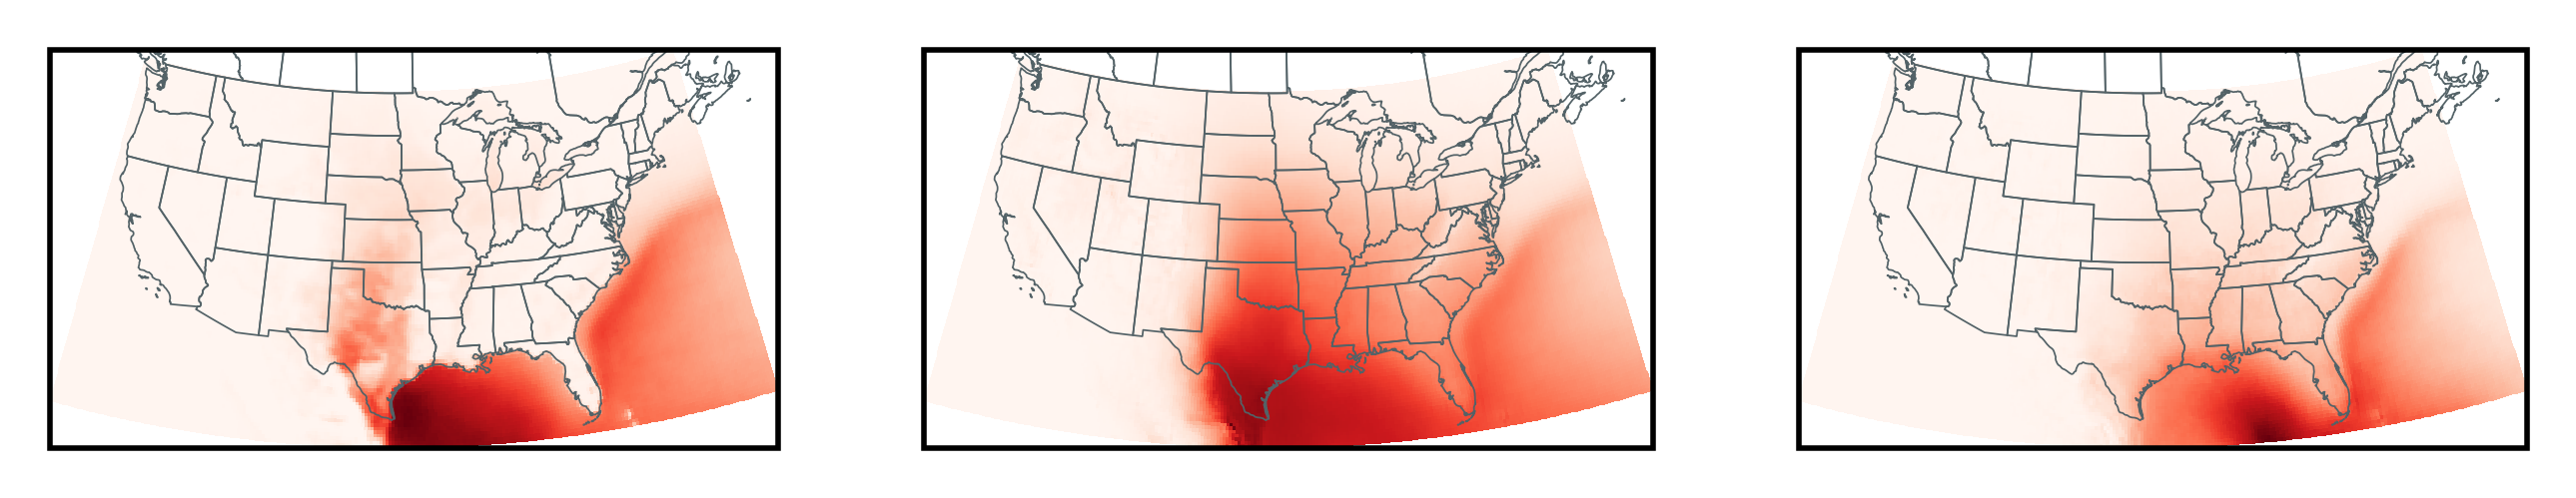

In [35]:
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

for i in range(3):
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')

ax[0].pcolormesh(s06_mam['longitude'], s06_mam['latitude'], ndsev_diff_trapp_xr.groupby('time.year').sum().mean(dim='year'), transform=ccrs.PlateCarree(), cmap='Reds')

ax[1].pcolormesh(s06_mam['longitude'], s06_mam['latitude'], ndsev_diff_trapp_old_xr.groupby('time.year').sum().mean(dim='year'), transform=ccrs.PlateCarree(), cmap='Reds')

ax[2].pcolormesh(s06_mam['longitude'], s06_mam['latitude'], ndsev_hoogewind_xr.groupby('time.year').sum().mean(dim='year'), transform=ccrs.PlateCarree(), cmap='Reds')


In [ ]:
# Save as a netcdf
# ndsev_hoogewind_xr.to_netcdf('/hurrell-scratch2/ivyglade/pdo/ndsev/hoogewind_ndsev_mam_1940-2024.nc')
# ndsev_diff_trapp_xr.to_netcdf('/hurrell-scratch2/ivyglade/pdo/ndsev/diff_trapp_ndsev_mam_1940-2024.nc')

# ndsev_hoogewind_de_xr.to_netcdf('/hurrell-scratch2/ivyglade/pdo/ndsev/hoogewind_de_ndsev_mam_1940-2024.nc')
# ndsev_diff_trapp_de_xr.to_netcdf('/hurrell-scratch2/ivyglade/pdo/ndsev/diff_trapp_de_ndsev_mam_1940-2024.nc')

In [ ]:
# Making a monthly count of NDSEV days
ndsev_count_hoogewind = np.zeros((255, 101, 237))
ndsev_count_trapp_diff = np.zeros((255, 101, 237))
for i in range(85):
    ndsev_count_hoogewind[i*3] = ndsev_hoogewind[i*92: i*92+31].sum(axis=0)
    ndsev_count_hoogewind[i*3 + 1] = ndsev_hoogewind[i*92+31:i*92+61].sum(axis=0)
    ndsev_count_hoogewind[i*3 + 2] = ndsev_hoogewind[i*92+61:(i+1)*92].sum(axis=0)

    ndsev_count_trapp_diff[i*3] = ndsev_trapp_diff[i*92: i*92+31].sum(axis=0)
    ndsev_count_trapp_diff[i*3 + 1] = ndsev_trapp_diff[i*92+31:i*92+61].sum(axis=0)
    ndsev_count_trapp_diff[i*3 + 2] = ndsev_trapp_diff[i*92+61:(i+1)*92].sum(axis=0)

In [ ]:
ndsev_count_hoogewind_de = np.zeros((255, 101, 237))
ndsev_count_trapp_diff_de = np.zeros((255, 101, 237))
for i in range(85):
    ndsev_count_hoogewind_de[i*3] = ndsev_hoogewind_de[i*92: i*92+31].sum(axis=0)
    ndsev_count_hoogewind_de[i*3 + 1] = ndsev_hoogewind_de[i*92+31:i*92+61].sum(axis=0)
    ndsev_count_hoogewind_de[i*3 + 2] = ndsev_hoogewind_de[i*92+61:(i+1)*92].sum(axis=0)

    ndsev_count_trapp_diff_de[i*3] = ndsev_trapp_diff_de[i*92: i*92+31].sum(axis=0)
    ndsev_count_trapp_diff_de[i*3 + 1] = ndsev_trapp_diff_de[i*92+31:i*92+61].sum(axis=0)
    ndsev_count_trapp_diff_de[i*3 + 2] = ndsev_trapp_diff_de[i*92+61:(i+1)*92].sum(axis=0)

In [ ]:
# Take time mean and fill zeros with nans
ndsev_count_hoog_mean = ndsev_count_hoogewind.mean(axis=0)
ndsev_count_diff_mean = ndsev_count_trapp_diff.mean(axis=0)
ndsev_count_hoog_mean_de = ndsev_count_hoogewind_de.mean(axis=0)
ndsev_count_diff_mean_de = ndsev_count_trapp_diff_de.mean(axis=0)

ndsev_count_hoog_mean[ndsev_count_hoog_mean == 0] = np.nan
ndsev_count_diff_mean[ndsev_count_diff_mean == 0] = np.nan
ndsev_count_hoog_mean_de[ndsev_count_hoog_mean_de == 0] = np.nan
ndsev_count_diff_mean_de[ndsev_count_diff_mean_de == 0] = np.nan

In [ ]:
# time array
time_arr = pd.date_range('1940-01', '2025-01', freq='MS')
time_arr_mam = time_arr[time_arr.month.isin([3, 4, 5])]

In [ ]:
# Convert ndsev to xr
ndsev_count_hoogewind_xr = xr.DataArray(ndsev_count_hoogewind, coords={'time':time_arr_mam, 'latitude':cape_mam['latitude'], 'longitude':cape_mam['longitude']}, dims=['time', 'latitude', 'longitude'])
ndsev_count_trapp_diff_xr = xr.DataArray(ndsev_count_trapp_diff, coords={'time':time_arr_mam, 'latitude':cape_mam['latitude'], 'longitude':cape_mam['longitude']}, dims=['time', 'latitude', 'longitude'])

ndsev_count_hoogewind_de_xr = xr.DataArray(ndsev_count_hoogewind_de, coords={'time':time_arr_mam, 'latitude':cape_mam['latitude'], 'longitude':cape_mam['longitude']}, dims=['time', 'latitude', 'longitude'])
ndsev_count_trapp_diff_de_xr = xr.DataArray(ndsev_count_trapp_diff_de, coords={'time':time_arr_mam, 'latitude':cape_mam['latitude'], 'longitude':cape_mam['longitude']}, dims=['time', 'latitude', 'longitude'])

In [ ]:
# Subset central US region
ndsev_count_hoogewind_east = ndsev_count_hoogewind_xr.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
ndsev_count_trapp_diff_east = ndsev_count_trapp_diff_xr.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

ndsev_count_hoogewind_east_de = ndsev_count_hoogewind_de_xr.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
ndsev_count_trapp_diff_east_de = ndsev_count_trapp_diff_de_xr.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

In [ ]:
# weight and take spatial average
ndsev_count_hoog_east_mean = ndsev_count_hoogewind_east.weighted(weights).mean(dim=('latitude', 'longitude'))
ndsev_count_diff_east_mean = ndsev_count_trapp_diff_east.weighted(weights).mean(dim=('latitude', 'longitude'))

ndsev_count_hoog_east_mean_de = ndsev_count_hoogewind_east_de.weighted(weights).mean(dim=('latitude', 'longitude'))
ndsev_count_diff_east_mean_de = ndsev_count_trapp_diff_east_de.weighted(weights).mean(dim=('latitude', 'longitude'))

In [ ]:
fig, ax = plt.subplots(1, 2)

time = np.arange(1940, 2025, 1/3)

ax[0].plot(time, ndsev_count_hoog_east_mean, label='no detrend', color='xkcd:grape')
ax[0].plot(time, ndsev_count_hoog_east_mean_de, label='degree 2 detrend', color='xkcd:light olive', linestyle='--')

ax[1].plot(time, ndsev_count_diff_east_mean, label='no detrend', color='xkcd:grape')
ax[1].plot(time, ndsev_count_diff_east_mean_de, label='degree 2 detrend', color='xkcd:light olive')

ax[0].legend(frameon=False, fontsize=8, handlelength=1)
ax[1].legend(frameon=False, fontsize=8, handlelength=1)

ax[0].set_ylabel('days month $^{-1}$')
ax[1].set_ylabel('days month $^{-1}$')

ax[0].set_xlabel('time')
ax[1].set_xlabel('time')

ax[0].set_title('Hoogewind et al. (2017)')
ax[1].set_title('Trapp (2007) and Diffenbaugh (2013)')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.6, 
                    wspace=0.2, 
                    hspace=0.2)

In [ ]:
# Load full colormap
cmap_full = cmr.fusion_r
cmap_full_other = cmr.fusion

# Extract first half (lower values)
cmap_half = c.LinearSegmentedColormap.from_list(
    'fusion_r_half',
    cmap_full(np.linspace(0.5, 1.0, 256))
)

cmap_other_half = c.LinearSegmentedColormap.from_list(
    'fusion_r_half',
    cmap_full_other(np.linspace(0.5, 1.0, 256))
)

In [ ]:
# land mask
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
era5_land = xr.where(land_110.mask_3D(cape)==True, 1, np.nan).squeeze()

In [ ]:
fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], \
      ax[1, 0], ax[1, 1]]

diff_bounds = [0, 0.75, 1.5, 2.25, 3, 4.5, 6, 7.5, 9, 12, 15, 18, 21]
diff_norm = c.BoundaryNorm(diff_bounds, cmap_half.N)

hoog_bounds = [0, 0.15, 0.3, 0.45, 0.6, 0.9, 1.2, 1.5, 1.8, 2.4, 3, 3.6, 4.2]
hoog_norm = c.BoundaryNorm(hoog_bounds, cmap_half.N)

for i in range(4):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')

ax[0].pcolormesh(cape_mam['longitude'], cape_mam['latitude'], ndsev_count_hoog_mean*era5_land, transform=ccrs.PlateCarree(), cmap=cmap_half, norm=hoog_norm)
ax[1].pcolormesh(cape_mam['longitude'], cape_mam['latitude'], ndsev_count_diff_mean*era5_land, transform=ccrs.PlateCarree(), cmap=cmap_half, norm=diff_norm)
ax[2].pcolormesh(cape_mam['longitude'], cape_mam['latitude'], ndsev_count_hoog_mean_de*era5_land, transform=ccrs.PlateCarree(), cmap=cmap_half, norm=hoog_norm)
ax[3].pcolormesh(cape_mam['longitude'], cape_mam['latitude'], ndsev_count_diff_mean_de*era5_land, transform=ccrs.PlateCarree(), cmap=cmap_half, norm=diff_norm)

ax[0].set_title('Hoogewind et al. (2017)')
ax[1].set_title('Trapp (2007) and Diffenbaugh (2013)')

cax = plt.axes([0.025, .21, 0.45, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_half, norm=hoog_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='max', \
                    ticks=[0, 0.6, 1.2, 1.8, 2.4, 3, 3.6, 4.2])
cbar.set_label(r'days month$^{-1}$', size=8, fontweight='normal', color='black', labelpad=0)
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black', pad=2)
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')

cax2 = plt.axes([0.525, .21, 0.45, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_half, norm=diff_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='max', \
                     ticks=[0, 3, 6, 9, 12, 15, 18, 21])
cbar2.set_label(r'days month$^{-1}$', size=8, fontweight='normal', color='black', labelpad=0)
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black', pad=2)
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')

ax[0].text(-2730000, 1500000, 'no detrend', fontweight='normal')
ax[1].text(-2730000, 1500000, 'no detrend', fontweight='normal')
ax[2].text(-2730000, 1500000, 'degree 2 polynomial detrend', fontweight='normal')
ax[3].text(-2730000, 1500000, 'degree 2 polynomial detrend', fontweight='normal')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1, 
                    wspace=0.05, 
                    hspace=0.2)

In [ ]:
fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], \
      ax[1, 0], ax[1, 1]]

cape_bounds = np.arange(0, 1575, 75)
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap(cmap_half).N)

cin_bounds = np.arange(0, 315, 15)
cin_norm = c.BoundaryNorm(cin_bounds, plt.get_cmap(cmap_other_half).N)

s06_bounds = np.arange(10, 26.8, 0.8)
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap(cmap_half).N)

capes06_bounds = np.arange(0, 26250, 1250)
capes06_norm = c.BoundaryNorm(capes06_bounds, plt.get_cmap(cmap_half).N)

for i in range(4):
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:grayish')

ax[0].pcolormesh(cape_mam_mean['longitude'], cape_mam_mean['latitude'], cape_mam_mean.mean(dim='year')*era5_land, transform=ccrs.PlateCarree(), shading='auto', cmap=cmap_half, norm=cape_norm)

ax[1].pcolormesh(cin_mam_mean['longitude'], cin_mam_mean['latitude'], cin_mam_mean.mean(dim='year')*era5_land, transform=ccrs.PlateCarree(), shading='auto', cmap=cmap_other_half, norm=cin_norm)

ax[2].pcolormesh(s06_mam_mean['longitude'], s06_mam_mean['latitude'], s06_mam_mean.mean(dim='year')*era5_land, transform=ccrs.PlateCarree(), shading='auto', cmap=cmap_half, norm=s06_norm)

ax[3].pcolormesh(s06_mam_mean['longitude'], s06_mam_mean['latitude'], cape_mam_mean.mean(dim='year')*s06_mam_mean.mean(dim='year')*era5_land, transform=ccrs.PlateCarree(), shading='auto', cmap=cmap_half, norm=capes06_norm)

ax[0].set_title('CAPE', fontsize=10, pad=2)
ax[1].set_title('CIN', fontsize=10, pad=2)
ax[2].set_title('S06', fontsize=10, pad=2)
ax[3].set_title('CAPES06', fontsize=10, pad=2)

cax = plt.axes([0.025, .71, 0.45, 0.01])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_half, norm=cape_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='max')
cbar.set_label(r'J kg$^{-1}$', size=8, fontweight='normal', color='black', labelpad=0)
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black', pad=2)
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')

cax2 = plt.axes([0.025, .25, 0.45, 0.01])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_half, norm=capes06_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='max')
cbar2.set_label(r'm$^3$ s$^{-3}$', size=8, fontweight='normal', color='black', labelpad=0.5)
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black', pad=2)
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')

cax3 = plt.axes([0.525, .71, 0.45, 0.01])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_other_half, norm=cin_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='max')
cbar3.set_label(r'J kg$^{-1}$', size=8, fontweight='normal', color='black', labelpad=0)
cbar3.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black', pad=2)
cbar3.outline.set_linewidth(0.5)
cbar3.outline.set_color('black')

cax4 = plt.axes([0.525, .25, 0.45, 0.01])
cbar4 = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_half, norm=ndsev_norm), cax=cax4, orientation='horizontal', spacing='proportional', extend='max')
cbar4.set_label(r'days season$^{-1}$', size=8, fontweight='normal', color='black', labelpad=0)
cbar4.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black', pad=2)
cbar4.outline.set_linewidth(0.5)
cbar4.outline.set_color('black')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.1, 
                    wspace=0.05, 
                    hspace=0.2)

In [ ]:
# Comparing NDSEV calculations
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

bounds1 = np.arange(0, 21, 1)
norm1 = c.BoundaryNorm(bounds1, plt.get_cmap(cmap_half).N)

bounds2 = np.arange(0, 63, 3)
norm2 = c.BoundaryNorm(bounds2, plt.get_cmap(cmap_half).N)

for i in range(3):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:grayish')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')

ax[0].pcolormesh(cape['longitude'], cape['latitude'], np.mean(ndsev_mam_mean, axis=0)*era5_land, transform=ccrs.PlateCarree(), shading='auto', cmap=cmap_half, norm=norm1)
ax[1].pcolormesh(cape['longitude'], cape['latitude'], np.mean(ndsev_nocin_mean, axis=0)*era5_land, transform=ccrs.PlateCarree(), shading='auto', cmap=cmap_half, norm=norm2)
ax[2].pcolormesh(cape['longitude'], cape['latitude'], np.mean(ndsev_csonly_mean,axis=0)*era5_land, transform=ccrs.PlateCarree(), shading='auto', cmap=cmap_half, norm=norm2)

ax[0].set_title('NDSEV', pad=1)
ax[1].set_title('NDSEV - no CIN', pad=1)
ax[2].set_title('NDSEV - CAPES06 only', pad=1)

cax = plt.axes([0.02, .36, 0.29, 0.01])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_half, norm=norm1), cax=cax, orientation='horizontal', spacing='proportional', extend='max')
cbar.set_label(r'days season$^{-1}$', size=6, fontweight='normal', color='black', labelpad=0)
cbar.ax.tick_params(which='both', labelsize=5, width=0.5, length=0, labelcolor='black', pad=2)
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')

cax2 = plt.axes([0.35, .36, 0.65, 0.01])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_half, norm=norm2), cax=cax2, orientation='horizontal', spacing='proportional', extend='max')
cbar2.set_label(r'days season$^{-1}$', size=6, fontweight='normal', color='black', labelpad=0)
cbar2.ax.tick_params(which='both', labelsize=5, width=0.5, length=0, labelcolor='black', pad=2)
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.5)

In [ ]:
fig, ax = plt.subplots( subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

bounds = np.arange(0, 84, 4)

norm = c.BoundaryNorm(bounds, plt.get_cmap(cmap_half).N)

ax.coastlines(lw=0.25, color='xkcd:gunmetal')
ax.spines['geo'].set_linewidth(0.25)
ax.spines['geo'].set_edgecolor('xkcd:gunmetal')
ax.add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
ax.set_facecolor('xkcd:grayish')

ax.pcolormesh(cape['longitude'], cape['latitude'], cin_thresh.sum(axis=3).mean(axis=0)*era5_land, transform=ccrs.PlateCarree(), shading='auto', cmap=cmap_half, norm=norm)

ax.set_title('# Days w/ CIN >= 100')

cax = plt.axes([0.05, .23, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap_half, norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='max')
cbar.set_label(r'days season$^{-1}$', size=10, fontweight='normal', color='black', labelpad=0)
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black', pad=2)
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')


plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1, 
                    wspace=0.05, 
                    hspace=0.5)